In [1]:
##################################################################################################
### This script is ML Classification template, which should be applicable to most MLC projects ###
##################################################################################################

"""Structure of the script:
1. Load all needed libraries and functions.
2. Load data, do preliminary data exploration.
3. [Optional] Transform skewed variables.
4. Trnasform features depending on their type. OHC.
5. Create subsamples.
6. Do scaling.
7. Fit models, selecting hyperparameters via CV grid search.
8. Evaluate performance of the selected models on test sample.
"""

'Structure of the script:\n1. Load all needed libraries and functions.\n2. Load data, do preliminary data exploration.\n3. [Optional] Transform skewed variables.\n4. Trnasform features depending on their type. OHC.\n5. Create subsamples.\n6. Do scaling.\n7. Fit models, selecting hyperparameters via CV grid search.\n8. Evaluate performance of the selected models on test sample.\n'

In [2]:
### 1.Load main libraries ###

import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier

pd.set_option('display.max_columns', 20)
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.expand_frame_repr', False)

In [3]:
def draw_histograms(df, variables, n_rows, n_cols):
    # stolen from https://stackoverflow.com/questions/29530355/plotting-multiple-histograms-in-grid
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()

In [4]:
### 2.Load data ###

path = '../input/titanic/train.csv'
df = pd.read_csv(path) # titanic_fullsample
print(df.shape)
df.drop(columns=['Name', 'Ticket', 'Cabin'],inplace=True)
df.loc[df.Age.isnull(),'Age'] = df.Age.median()
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


       PassengerId    Survived      Pclass         Age       SibSp       Parch        Fare
count   891.000000  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000
mean    446.000000    0.383838    2.308642   29.361582    0.523008    0.381594   32.204208
std     257.353842    0.486592    0.836071   13.019697    1.102743    0.806057   49.693429
min       1.000000    0.000000    1.000000    0.420000    0.000000    0.000000    0.000000
25%     223.500000    0.000000    2.000000   22.000000    0.000000    0.000000    7.910400
50%     446.000000    0.000000    3.000000   28.000000    0.000000    0.000000   14.454200
75%     668.500000    1.000000    3.000000   35.000000    1.000000    0.000000   31.000000
max     891.000000    1.000000    3.000000   80.000000    8.000000    6.000000  512.329200


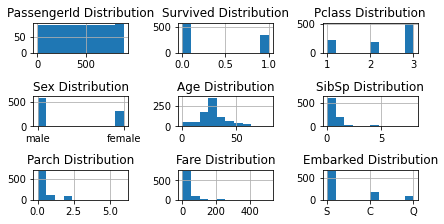

In [5]:
print(df.describe())
# sns.pairplot(df[['Survived', 'Pclass', 'Age', 'Fare']])
draw_histograms(df, df.columns, 4, 3)

In [6]:
#%% 3.Transform some skewed variables ###

df['Fare'] = np.log1p(df.Fare)

In [7]:
#%% 4.Transform features depending on their type ###

# this is very important for ML application, where there are hundreds of features.
# If there are less than 20 features, can use standard approach.
# my approach of tackling one feature a time is not scalable. 

# use intuition to trim range or ordinary variables 
# can skip this step in general, since it is not scalable when number of features grows.
df.loc[df.SibSp>2,'SibSp']=3
df.loc[df.Parch>2,'Parch']=3

# identify binary and categorical variables
df_uniques = pd.DataFrame([[i, len(df[i].unique())] for i in df.columns], columns=['Variable', 'Unique Values']).set_index('Variable')
print(df_uniques)

binary_variables = list(df_uniques[df_uniques['Unique Values'] == 2].index)
categorical_variables = list(df_uniques[(6 >= df_uniques['Unique Values']) & (df_uniques['Unique Values'] > 2)].index)
numeric_variables = list(set(df.columns) - set(categorical_variables) - set(binary_variables))
print('Binary variables are ', binary_variables)
print('Categorical variables are ', categorical_variables)
print('Numeric variables are ', numeric_variables)

             Unique Values
Variable                  
PassengerId            891
Survived                 2
Pclass                   3
Sex                      2
Age                     88
SibSp                    4
Parch                    4
Fare                   248
Embarked                 4
Binary variables are  ['Survived', 'Sex']
Categorical variables are  ['Pclass', 'SibSp', 'Parch', 'Embarked']
Numeric variables are  ['Fare', 'PassengerId', 'Age']


In [8]:
# ohc for binary variables #
lb = LabelBinarizer()
binary_variables.remove('Survived')
for column in binary_variables:
    df[column] = lb.fit_transform(df[column])

# ohc for categorical variables #
df = pd.get_dummies(df, columns = categorical_variables, drop_first=True)

print(df.shape)
print(df.head())

(891, 15)
   PassengerId  Survived  Sex   Age      Fare  Pclass_2  Pclass_3  SibSp_1  SibSp_2  SibSp_3  Parch_1  Parch_2  Parch_3  Embarked_Q  Embarked_S
0            1         0    1  22.0  2.110213         0         1        1        0        0        0        0        0           0           1
1            2         1    0  38.0  4.280593         0         0        1        0        0        0        0        0           0           0
2            3         1    0  26.0  2.188856         0         1        0        0        0        0        0        0           0           1
3            4         1    0  35.0  3.990834         0         0        1        0        0        0        0        0           0           1
4            5         0    1  35.0  2.202765         0         1        0        0        0        0        0        0           0           1


In [9]:
# %% 5.Creating subsamples ###

y = df['Survived']
X = df.drop(columns=['Survived'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

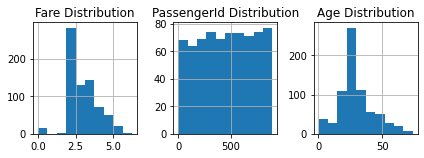

In [10]:
# %% 6.scaling numeric variables ###

draw_histograms(X_train, numeric_variables, 2, 3)

In [11]:
ss = StandardScaler()

for column in [numeric_variables]:
    X_train[column] = ss.fit_transform(X_train[column])
    X_test[column] = ss.transform(X_test[column])

In [12]:
####################
### 7.Fit models ###
####################

#%% Logistic regression ###

grid_values = {'penalty': ['l2'], 'C': list(np.arange(1,10.5,0.5))}
lr = LogisticRegression()
model_lr = GridSearchCV(lr, param_grid=grid_values, cv = 10)
model_lr.fit(X_train, y_train)
print(model_lr.best_score_, model_lr.best_params_)

# model_lr.predict(X_test)

0.8147300469483568 {'C': 3.0, 'penalty': 'l2'}


In [13]:
#%% KNN ###

grid_values = dict(n_neighbors=np.arange(1,40))
knnm = KNeighborsClassifier()   
model_knn = GridSearchCV(knnm, param_grid=grid_values, cv = 10)
model_knn.fit(X_train, y_train)
print(model_knn.best_score_, model_knn.best_params_)

0.8020148669796556 {'n_neighbors': 8}


In [14]:
#%% SVM ###

grid_values = {'C': np.arange(0.05, 1, 0.05)} 
svmm = svm.SVC(kernel='rbf')
model_svm = GridSearchCV(svmm, param_grid=grid_values, cv = 10)
model_svm.fit(X_train, y_train)
print(model_svm.best_score_, model_svm.best_params_)

0.8034428794992176 {'C': 0.9000000000000001}


In [15]:
#%% RF ###

# may look here: https://www.geeksforgeeks.org/hyperparameter-tuning/

grid_values = [{'max_depth': list(range(2, 9, 2)), 'max_features': list(np.arange(0.3,0.71,0.1))}]
rfc = RandomForestClassifier(random_state=42)
model_rf = GridSearchCV(rfc, grid_values, cv = 5, scoring='accuracy')
model_rf.fit(X_train, y_train)
print(model_rf.best_score_, model_rf.best_params_)

0.8286811779769525 {'max_depth': 8, 'max_features': 0.6000000000000001}


In [16]:
#%% XGBoost ###
# run this code only on Kaggle with GPU

estimator = XGBClassifier(
    nthread=4,
    seed=42,
    use_label_encoder=False
)

parameters = {
    'max_depth': range (2, 5, 1),
    'n_estimators': range(5, 50, 5),
    'learning_rate': [0.01, 0.05, 0.1, 0.15]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)

grid_search.fit(X_train, y_train, eval_metric='rmse')
print(grid_search.best_score_, grid_search.best_params_)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
0.8678841991341992 {'learning_rate': 0.15, 'max_depth': 3, 'n_estimators': 35}


In [17]:
#%% 8.Evaluate performance oos ###

yhat_lm = model_lr.predict(X_test)
yhat_knn = model_knn.predict(X_test)
yhat_svm = model_svm.predict(X_test)
yhat_rf = model_rf.predict(X_test)
#yhat_bt = grid_search.predict(X_test)
print('Accuracy of logistic regression is ', 1-(np.abs(yhat_lm-y_test)).mean())
print('Accuracy of KNN is ', 1-(np.abs(yhat_knn-y_test)).mean())
print('Accuracy of SVM is ', 1-(np.abs(yhat_svm-y_test)).mean())
print('Accuracy of RF is ', 1-(np.abs(yhat_rf-y_test)).mean())
#print('Accuracy of Boosted Tree is ', 1-(np.abs(yhat_bt-y_test)).mean())

Accuracy of logistic regression is  0.7653631284916201
Accuracy of KNN is  0.7988826815642458
Accuracy of SVM is  0.7988826815642458
Accuracy of RF is  0.8268156424581006
